<a id = '5.5'></a>
<p style = "font-size : 25px; color : #34656d ; font-family : 'Comic Sans MS'; text-align : center; background-color : #fbc6a4; border-radius: 5px 5px;"><strong>Flight Price Prediction</strong></p>

This demo is adapted from kaggle demo: https://www.kaggle.com/code/anshigupta01/flight-price-prediction

## 环境配置
假设大家已安装Python。
在命令行里安装以下Python库
```
pip install numpy pandas scikit-learn
```


## 数据处理

In [1]:
#importing libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

#importing data
df=pd.read_excel('/Users/zhuerle/Documents/personal-info/社工志愿/2024未央城赛事/data/Data_Train_flight.xlsx') # 运行时替换为自己的文件路径
print("Original data: ")
print(df.head())
print(df.info())   #information about the data
#describe about the data
print(df.describe())
print(df.shape)  #shape of the data

"""
Dealing with the missing values
"""
#finding the null values
df.isnull().sum()
import missingno as msno
# msno.bar(df)
# plt.show()
#drop the nullvalues
df.dropna(inplace=True)
df.isnull().sum()
df.dtypes # datatypes

"""
Dealing with the date and time
"""
def change_into_datetime(col):
    df[col]=pd.to_datetime(df[col])

df.columns
for i in ['Date_of_Journey','Dep_Time', 'Arrival_Time']:
    change_into_datetime(i)

df['journey_day']=df['Date_of_Journey'].dt.day
df['journey_month']=df['Date_of_Journey'].dt.month
df.drop('Date_of_Journey', axis=1, inplace=True)

# function for extracting hour and minutes
def extract_hour(data,col):
    data[col+'_hour']=data[col].dt.hour
    
def extract_min(data,col):
    data[col+'_min']=data[col].dt.minute
    

def drop_col(data,col):
    data.drop(col,axis=1,inplace=True)

#call the function
# Departure time is when a plane leaves the gate. 
# Similar to Date_of_Journey we can extract values from Dep_Time
extract_hour(df,'Dep_Time')

#extracting minutes
extract_min(df,'Dep_Time')

#drop the column
drop_col(df,'Dep_Time')

#extracting hour
extract_hour(df,'Arrival_Time')

#extracting min
extract_min(df,'Arrival_Time')


#drop the column
drop_col(df,'Arrival_Time')

duration=list(df['Duration'])
for i in range(len(duration)):
    if len(duration[i].split(' '))==2:
        pass
    else:
        if 'h' in duration[i]: # Check if duration contains only hour
             duration[i]=duration[i] + ' 0m' # Adds 0 minute
        else:
             duration[i]='0h '+ duration[i] # if duration contains only second, Adds 0 hour
df['Duration']=duration
df.head()

def hour(x):
    return x.split(' ')[0][0:-1]

def minutes(x):
    return x.split(' ')[1][0:-1]

df['dur_hour']=df['Duration'].apply(hour)
df['dur_min']=df['Duration'].apply(minutes)
df.head(10)
drop_col(df,'Duration')
df.dtypes

df['dur_hour'] = df['dur_hour'].astype(int)
df['dur_min'] = df['dur_min'].astype(int)
df.dtypes

""" 
Dealing with the categorical data
"""
column=[column for column in df.columns if df[column].dtype=='object']
column

continuous_col =[column for column in df.columns if df[column].dtype!='object']
continuous_col
categorical = df[column]
categorical.head()
categorical['Airline'].value_counts()

# plt.figure(figsize=(15,8))
# sns.boxplot(x='Airline',y='Price',data=df.sort_values('Price',ascending=False))

# plt.figure(figsize=(15,8))
# sns.boxplot(x='Total_Stops',y='Price',data=df.sort_values('Price',ascending=False))

# As Airline is Nominal Categorical data we will perform OneHotEncoding
Airline=pd.get_dummies(categorical['Airline'],drop_first=True)
Airline.head()
categorical['Source'].value_counts()

#Source vs Price

# plt.figure(figsize=(15,15))
# sns.catplot(x='Source',y='Price',data=df.sort_values('Price',ascending=False),kind='boxen')
#encoding of source column
source=pd.get_dummies(categorical['Source'],drop_first=True)
source.head()

categorical['Destination'].value_counts()

# plt.figure(figsize=(15,8))
# sns.boxplot(x='Destination',y='Price',data=df.sort_values('Price',ascending=False))

#encoding of destination column
destination=pd.get_dummies(categorical['Destination'],drop_first=True)
destination.head()

# now work on route column
categorical['Route'].value_counts()

categorical['Route1']=categorical['Route'].str.split('→').str[0]
categorical['Route2']=categorical['Route'].str.split('→').str[1]
categorical['Route3']=categorical['Route'].str.split('→').str[2]
categorical['Route4']=categorical['Route'].str.split('→').str[3]
categorical['Route5']=categorical['Route'].str.split('→').str[4]

categorical.head()
drop_col(categorical,'Route')
categorical.isnull().sum()
categorical.columns

for i in ['Route3', 'Route4', 'Route5']:
    categorical[i].fillna('None',inplace=True)

categorical.isnull().sum()

for i in categorical.columns:
    print('{} has total {} categories'.format(i,len(categorical[i].value_counts())))

# df.plot.hexbin(x='Arrival_Time_hour',y='Price',gridsize=15)
# Applying label encoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

for i in ['Route1', 'Route2', 'Route3', 'Route4', 'Route5']:
    categorical[i]=encoder.fit_transform(categorical[i])
categorical.head()
drop_col(categorical,'Additional_Info')
categorical['Total_Stops'].unique()
# encoding Total stops
dict={'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}
categorical['Total_Stops']=categorical['Total_Stops'].map(dict)

categorical['Total_Stops']
drop_col(categorical,'Source')
drop_col(categorical,'Destination')
drop_col(categorical,'Airline')
final_df=pd.concat([categorical,Airline,source,destination,df[continuous_col]],axis=1)

# print("\n\nFinal data:")
# print(final_df.head())
# print(final_df.info())
# print(final_df.describe())
# print(final_df.shape)

Original data: 
       Airline Date_of_Journey    Source Destination                  Route  \
0       IndiGo      24/03/2019  Banglore   New Delhi              BLR → DEL   
1    Air India       1/05/2019   Kolkata    Banglore  CCU → IXR → BBI → BLR   
2  Jet Airways       9/06/2019     Delhi      Cochin  DEL → LKO → BOM → COK   
3       IndiGo      12/05/2019   Kolkata    Banglore        CCU → NAG → BLR   
4       IndiGo      01/03/2019  Banglore   New Delhi        BLR → NAG → DEL   

  Dep_Time  Arrival_Time Duration Total_Stops Additional_Info  Price  
0    22:20  01:10 22 Mar   2h 50m    non-stop         No info   3897  
1    05:50         13:15   7h 25m     2 stops         No info   7662  
2    09:25  04:25 10 Jun      19h     2 stops         No info  13882  
3    18:05         23:30   5h 25m      1 stop         No info   6218  
4    16:50         21:35   4h 45m      1 stop         No info  13302  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data co

In [2]:
num_col = final_df.shape[1]
pd.set_option('display.max_columns', num_col)
final_df.head(5) # 显示前5行数据

,Total_Stops,Route1,Route2,Route3,Route4,Route5,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,dur_hour,dur_min
0,0,0,13,29,13,5,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,3897,24,3,22,20,1,10,2,50
1,2,2,25,1,3,5,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,7662,1,5,5,50,13,15,7,25
2,2,3,32,4,5,5,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,13882,9,6,9,25,4,25,19,0
3,1,2,34,3,13,5,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,6218,12,5,18,5,23,30,5,25
4,1,0,34,8,13,5,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,13302,1,3,16,50,21,35,4,45


In [3]:
final_df.info() # 查看数据类型

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Total_Stops                        10682 non-null  int64
 1   Route1                             10682 non-null  int64
 2   Route2                             10682 non-null  int64
 3   Route3                             10682 non-null  int64
 4   Route4                             10682 non-null  int64
 5   Route5                             10682 non-null  int64
 6   Air India                          10682 non-null  bool 
 7   GoAir                              10682 non-null  bool 
 8   IndiGo                             10682 non-null  bool 
 9   Jet Airways                        10682 non-null  bool 
 10  Jet Airways Business               10682 non-null  bool 
 11  Multiple carriers                  10682 non-null  bool 
 12  Multiple carriers Premi

经过数据处理部分，原始特征被转成了35维度的特征向量，且为可以进行数值运算的int类型和bool类型，接下来。
数据处理流程后，我们要对这些特征数据进行建模。

## 建模

### 数据集划分
建模的第一步是划分数据集，我们将训练集划分成训练集和预测试集（验证集），这里我们使用 `sklearn.model_selection` 里的 `train_test_split`。

In [4]:
## seprate the dataset in X and y
X=final_df.drop('Price',axis=1) # 标签维度剔除
y=df['Price'] # 标签维度

# spiliting the dataset - train:test = 8:2
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.20, random_state=123)

### 建模过程
选择不同的模型和超参数，进行优化和评估。

我们通过编写predict()函数封装模型的优化、评估过程。

In [5]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
def predict(ml_model, show_figure=True):
    print('Model is: {}'.format(ml_model))

    # Model Optimization
    model= ml_model.fit(X_train,y_train) # 通过fit函数实现模型优化
    print("Training score: {}".format(model.score(X_train,y_train))) # 输出训练集上的R2分数，可以表明训练集合上的拟合程度
    predictions = model.predict(X_test) # 通过predict函数实现预测
    # print("Predictions are: {}".format(predictions))
    print('\n')

    # Model Evaluation
    r2score=r2_score(y_test,predictions) # 通过r2_score函数实现R2分数的计算
    print("r2 score is: {}".format(r2score))
    
    mae = mean_absolute_error(y_test,predictions) # 通过mean_absolute_error函数实现MAE的计算
    abs_error = np.abs(predictions-y_test)  # 计算绝对误差
    rel_error = abs_error / np.array(y_test) # 计算相对误差
    mre = np.mean(rel_error) # 计算平均相对误差
    print('MAE:{}'.format(mae))
    print('MSE:{}'.format(mean_squared_error(y_test,predictions)))
    print('RMSE:{}'.format(np.sqrt(mean_squared_error(y_test,predictions))))
    print('MRE:{}%'.format(mre*100))
    
    if show_figure: # 如果要画图
        # 误差密度图
        sns.distplot(y_test-predictions)
        
        # range_x_left = float(max(y_test))*1.1
        # 绝对误差图
        range_x_left = float(max(y_test))*0.6
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, abs_error, color='blue', s=5)
        plt.plot(np.linspace(0, range_x_left, 1000), [mae]*1000, linewidth=1.5)
        plt.xlabel('Actual Price')
        plt.ylabel('Prediction Error')
        plt.xlim(0, range_x_left)
        plt.ylim(0, max(abs_error)*1.1)
        plt.legend(['Absolute Error', 'Mean Absolute Error'])
        plt.title('Absulute Error vs. Actual Price')

        # 相对误差图
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, rel_error*100, color='red', s=5)
        plt.plot(np.linspace(0, range_x_left, 1000), [mre*100]*1000, linewidth=1.5, color='brown')
        plt.xlabel('Actual Price')
        plt.xlim(0, range_x_left)
        plt.ylim(0, max(rel_error)*110)
        plt.ylabel('Relative Prediction Error / %')
        plt.legend(['Relative Error', 'Mean Relative Error'])
        plt.title('Relative Error vs. Actual Price')

Model is: RandomForestRegressor()
Training score: 0.953368584806051


r2 score is: 0.8417399956214349
MAE:1088.2497030180473
MSE:3047403.6140622366
RMSE:1745.6814182611433
MRE:12.163924966760419%


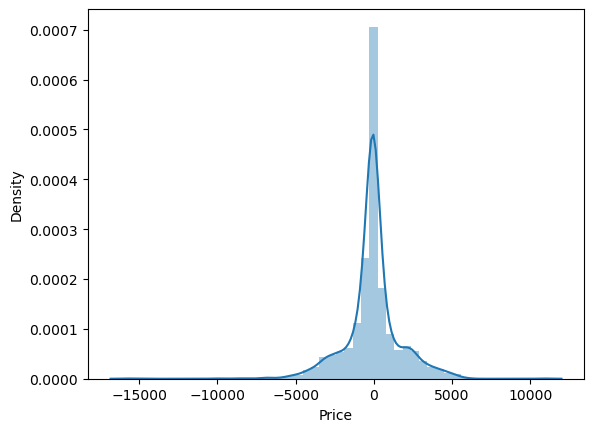

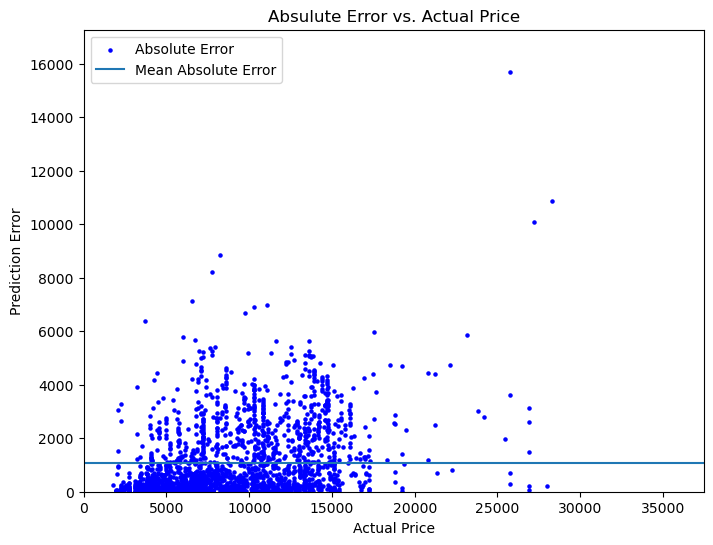

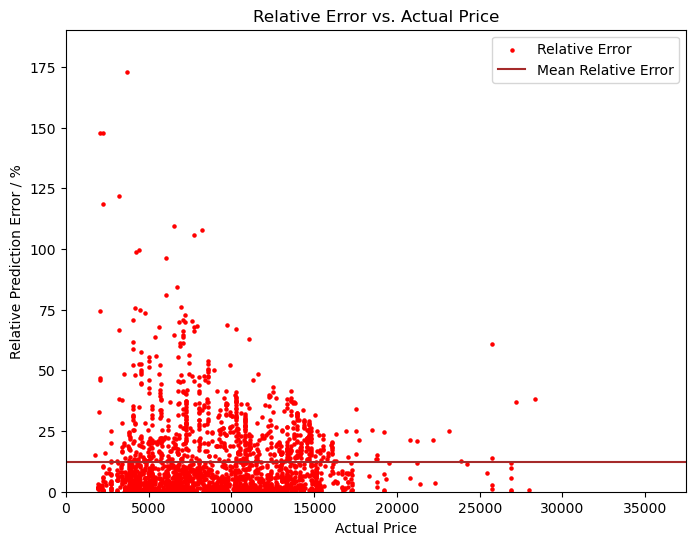

In [6]:
# 用随机森林算法测试一下predict函数
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
predict(model, show_figure=True)

对于一些敏感型变量，我们会采用MRE衡量预测效果，对于价格，我们直接用绝对误差MAE衡量即可。

## 算法性能分析

### 线性回归

In [7]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

# Linear Regression
print("*"*20 + "Linear Regression" + "*"*20)
LRmodel = LinearRegression()
predict(LRmodel, show_figure=False)
print("*"*60)

# Lasso Regression
print("*"*20 + "Lasso Regression" + "*"*20) # 一次正则项
Lasso_model = Lasso()
predict(Lasso_model, show_figure=False)
print("*"*60)

# Ridge Regression
print("*"*20 + "Ridge Regression" + "*"*20) # 二次正则项
Ridge_model = Ridge()
predict(Ridge_model, show_figure=False)
print("*"*60)

# ElasticNet Regression
print("*"*20 + "ElasticNet Regression" + "*"*20) # 一次和二次正则项
ElasticNet_model = ElasticNet()
predict(ElasticNet_model, show_figure=False)
print("*"*60)

********************Linear Regression********************
Model is: LinearRegression()
Training score: 0.626336144292348


r2 score is: 0.6599604843678437
MAE:1852.007370145063
MSE:6547691.268747075
RMSE:2558.8456906869305
MRE:22.770253506694207%
************************************************************
********************Lasso Regression********************
Model is: Lasso()
Training score: 0.6260581333816179


r2 score is: 0.6601121790287069
MAE:1850.3398275526822
MSE:6544770.28527078
RMSE:2558.274865074271
MRE:22.757626576325272%
************************************************************
********************Ridge Regression********************
Model is: Ridge()
Training score: 0.6247440488387421


r2 score is: 0.6571877990848141
MAE:1855.0469624549648
MSE:6601081.202516762
RMSE:2569.2569358701285
MRE:22.793015550341085%
************************************************************
********************ElasticNet Regression********************
Model is: ElasticNet()
Training scor

上述结果说明数据的线性可分性较差，我们可以尝试引入核方法，将线性可分变为线性不可分。

我们可以尝试核岭回归（Kernel Ridge Regression），引入核方法和二次正则项。

In [9]:
from sklearn.kernel_ridge import KernelRidge

# 采用线性基函数
print("*"*20 + "KernelRidge Regression, kernel='linear'" + "*"*20)
KR_model = KernelRidge(kernel='linear')
predict(KR_model, show_figure=False)
print("*"*60)

# 采用多项式基函数
print("*"*20 + "KernelRidge Regression, kernel='poly'" + "*"*20)
KR_model = KernelRidge(kernel='poly')
predict(KR_model, show_figure=False)
print("*"*60)

# 采用径向基函数
print("*"*20 + "KernelRidge Regression, kernel='rbf'" + "*"*20)
KR_model = KernelRidge(kernel='rbf')
predict(KR_model, show_figure=False)
print("*"*60)

********************KernelRidge Regression, kernel='linear'********************
Model is: KernelRidge()
Training score: 0.624586152731802
Predictions are: [ 9744.5915596  13406.72827604 11753.75981176 ...  6817.67494581
  6521.62101597 12479.93040868]


r2 score is: 0.656923898818287
MAE:1856.596078538535
MSE:6606162.780955509
RMSE:2570.2456654871553
MRE:22.78782905748273%
************************************************************
********************KernelRidge Regression, kernel='poly'********************
Model is: KernelRidge(kernel='poly')
Training score: 0.8495584672004719
Predictions are: [ 8495.33286687 17164.9061464  12836.89893984 ...  4914.39503769
  4169.3736202  11446.43869401]


r2 score is: 0.6862105897440958
MAE:1422.5768589289505
MSE:6042227.703854495
RMSE:2458.094323628468
MRE:16.526944369615936%
************************************************************
********************KernelRidge Regression, kernel='rbf'********************
Model is: KernelRidge(kernel='rbf')

可以看到，引入多项式基函数的拟合效果更好一些。

### 决策树回归

决策树的一大优点是它的可解释性，我们可以通过可视化来对决策树模型的决策进行解释。

可视化决策树可能需要额外的一些软件和python库依赖。下面是使用graphviz可视化的要求：
- 第一步是安装graphviz。下载地址在：http://www.graphviz.org/
- 第二步是安装python插件graphviz： `pip install graphviz`
- 第三步是安装python插件pydotplus： `pip install pydotplus`
- 安装完之后要重启notebook的kernel（点击上方的`Restart`，`Run All`），才能正确运行

Model is: DecisionTreeRegressor(max_depth=5)
Training score: 0.6826469798645802
Predictions are: [ 6091.22735675 12051.19540906 12051.19540906 ...  6091.22735675
  8134.91722099 12051.19540906]


r2 score is: 0.655371961068981
MAE:1828.7703282064704
MSE:6636046.39384056
RMSE:2576.0524827418712
MRE:22.65425268888118%


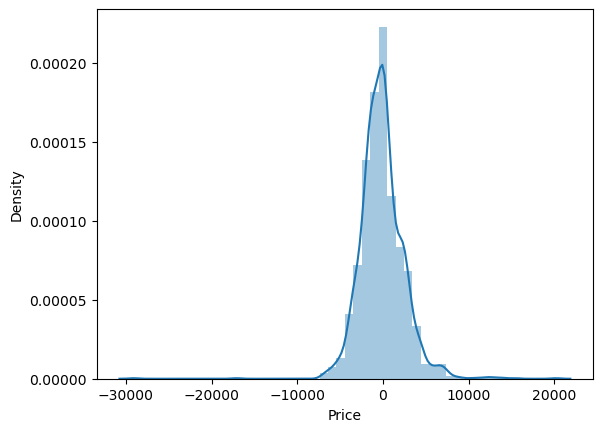

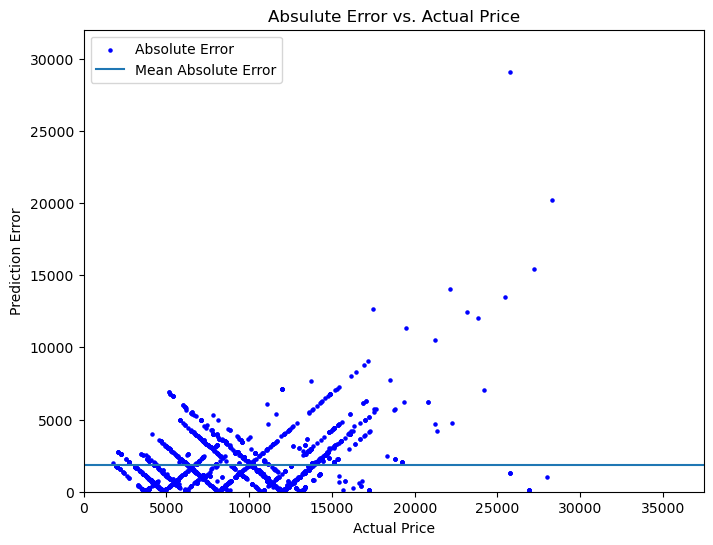

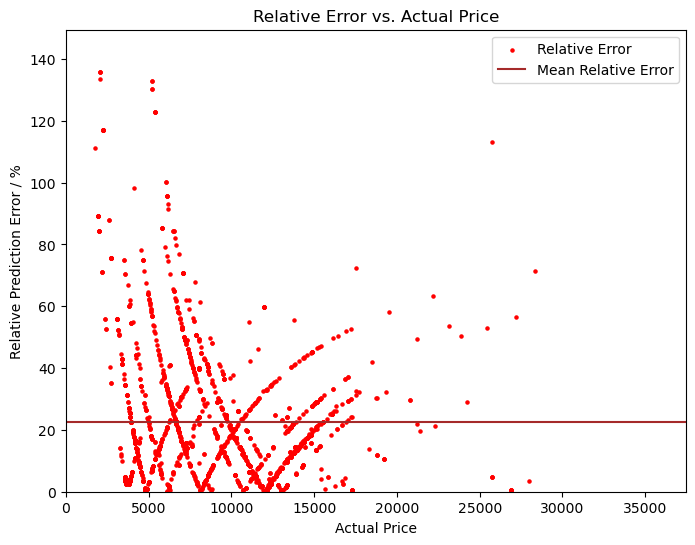

In [10]:
#构建模型（回归）
from sklearn.tree import DecisionTreeRegressor
DTmodel = DecisionTreeRegressor(max_depth=5)
#模型预测
predict(DTmodel)

Index(['Total_Stops', 'Route1', 'Route2', 'Route3', 'Route4', 'Route5',
       'Air India', 'GoAir', 'IndiGo', 'Jet Airways', 'Jet Airways Business',
       'Multiple carriers', 'Multiple carriers Premium economy', 'SpiceJet',
       'Trujet', 'Vistara', 'Vistara Premium economy', 'Chennai', 'Delhi',
       'Kolkata', 'Mumbai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'New Delhi', 'journey_day', 'journey_month', 'Dep_Time_hour',
       'Dep_Time_min', 'Arrival_Time_hour', 'Arrival_Time_min', 'dur_hour',
       'dur_min'],
      dtype='object')


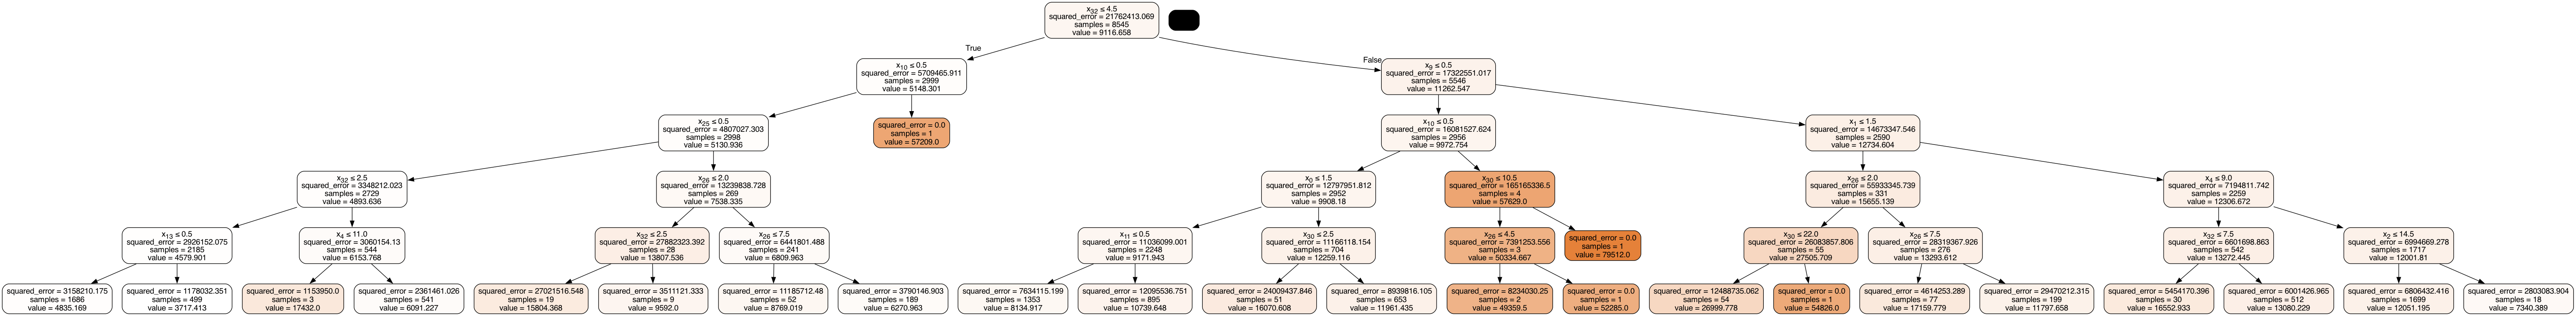

In [11]:
# 可视化决策树，这部分需要安装额外依赖
from sklearn import tree
from IPython.display import Image  
import pydotplus
dot_data = tree.export_graphviz(DTmodel, out_file=None,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data) 
print(X_train.columns)
Image(graph.create_png())

In [12]:
# 调整决策树参数，以决策树深度为例
print("*"*20 + "Decision Tree with max_depth=5" + "*"*20)
DTmodel_1 = DecisionTreeRegressor(max_depth=5)
predict(DTmodel_1, show_figure=False)
print("*"*60)

print("*"*20 + "Decision Tree with max_depth=10" + "*"*20)
DTmodel_2 = DecisionTreeRegressor(max_depth=10)
predict(DTmodel_2, show_figure=False)
print("*"*60)

print("*"*20 + "Decision Tree with max_depth=15" + "*"*20)
DTmodel_3 = DecisionTreeRegressor(max_depth=15)
predict(DTmodel_3, show_figure=False)
print("*"*60)

********************Decision Tree with max_depth=5********************
Model is: DecisionTreeRegressor(max_depth=5)
Training score: 0.6826469798645802
Predictions are: [ 6091.22735675 12051.19540906 12051.19540906 ...  6091.22735675
  8134.91722099 12051.19540906]


r2 score is: 0.655371961068981
MAE:1828.7703282064704
MSE:6636046.39384056
RMSE:2576.0524827418712
MRE:22.65425268888118%
************************************************************
********************Decision Tree with max_depth=10********************
Model is: DecisionTreeRegressor(max_depth=10)
Training score: 0.8749364914254678
Predictions are: [ 8515.57142857 16296.48       12733.39322034 ...  4011.58333333
  5852.38947368 10840.63461538]


r2 score is: 0.819330965253048
MAE:1227.5873687056003
MSE:3478904.6771413255
RMSE:1865.1822101717905
MRE:14.272621426046694%
************************************************************
********************Decision Tree with max_depth=15********************
Model is: DecisionTreeR

### 随机森林
原理回顾：
- 个体学习器： 随机森林采用决策树（CART树）作为个体学习器，可同时用于分类和回归
- 结合策略：
    - 假设训练集为${(x_1,y_1), …, (x_m,y_m)}$
    - 并行训练𝑇棵决策树（CART树）
    - 自助采样（Bootstrap Sampling）: 对每个个体学习器$h_t$（CART树），从训练集有放回采样𝑚条数据（有重复），作为每个个体学习器的训练数据$𝐷_t$
    - 随机特征维度选择：在用$𝐷_t$训练每一棵CART树时，对每一次节点分裂，先从属性集合随机选择𝑘个属性，再从𝑘个属性中选择最优属性进行下一步划分
- 预测：根据所有决策树的预测结果，做投票（分类）或平均（回归）


这里我们使用`RandomizedSearchCV`算法进行超参数搜索。

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# 设置要搜索超参数的范围
random_grid = {
    'n_estimators' : [100, 120, 150, 180, 200,220], # 随机森林中树的数量
    'max_features':['auto','sqrt'], # 节点分裂时考虑的最大特征数，有两种策略：auto和sqrt
    'max_depth':[5,10,15,20], # 树的最大深度
}

rf=RandomForestRegressor()
# 构建随机搜索模型
rf_random=RandomizedSearchCV(estimator=rf, param_distributions=random_grid,cv=3,verbose=2,n_jobs=-1,)

rf_random.fit(X_train,y_train)

# best parameter
rf_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END ..max_depth=15, max_features=sqrt, n_estimators=150; total time=   0.7s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=150; total time=   0.7s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=150; total time=   0.7s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=150; total time=   0.8s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=150; total time=   0.9s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.0s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.0s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.0s


/Users/zhuerle/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END ..max_depth=20, max_features=sqrt, n_estimators=120; total time=   0.6s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=150; total time=   0.5s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=120; total time=   0.6s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=150; total time=   0.5s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=150; total time=   0.8s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=120; total time=   0.7s


/Users/zhuerle/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/zhuerle/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/zhuerle/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also th

[CV] END ..max_depth=10, max_features=sqrt, n_estimators=150; total time=   0.5s


/Users/zhuerle/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END ..max_depth=10, max_features=auto, n_estimators=120; total time=   1.6s
[CV] END ..max_depth=10, max_features=auto, n_estimators=120; total time=   1.6s
[CV] END ..max_depth=10, max_features=auto, n_estimators=150; total time=   1.9s


/Users/zhuerle/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END ..max_depth=10, max_features=auto, n_estimators=150; total time=   1.9s
[CV] END ..max_depth=10, max_features=auto, n_estimators=150; total time=   2.0s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=180; total time=   0.8s
[CV] END ..max_depth=10, max_features=auto, n_estimators=120; total time=   1.3s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=180; total time=   0.8s
[CV] END ..max_depth=15, max_features=sqrt, n_estimators=180; total time=   0.7s
[CV] END ..max_depth=20, max_features=auto, n_estimators=220; total time=   3.8s
[CV] END ..max_depth=20, max_features=auto, n_estimators=220; total time=   3.7s
[CV] END ..max_depth=20, max_features=auto, n_estimators=220; total time=   3.7s


{'n_estimators': 120, 'max_features': 'auto', 'max_depth': 10}

In [14]:
# 采用默认参数的随机森林模型
predict(RandomForestRegressor(), show_figure=False)

Model is: RandomForestRegressor()
Training score: 0.9520532129982289
Predictions are: [ 8390.04833333 17516.69       13877.74533333 ...  3831.54
  5823.06       10616.20666667]


r2 score is: 0.8409063020142141
MAE:1086.7279783965062
MSE:3063456.949341994
RMSE:1750.2733927424006
MRE:12.14281461771953%


In [8]:
# 采用调整后的参数的随机森林模型
predict(RandomForestRegressor(n_estimators=120, max_features='auto', max_depth=15), show_figure=False)

Model is: RandomForestRegressor(max_depth=15, max_features='auto', n_estimators=120)
Training score: 0.9431575442447547


r2 score is: 0.8586653870067545
MAE:1051.2445460769018
MSE:2721493.7350655003
RMSE:1649.695043050533
MRE:11.789643044623093%


可以看到经过超参数调优后的随机森林具有更好的表现。